In this notebook we reproduce void catalogs from SDSS DR12 as well as the DESI UNIT sims QSO and LRG tracers. 

## Set Up ##

### Preliminary set up

In [1]:
#checking where I am
!pwd 

/global/u2/c/chanun/cosmic_voids/doc


In [51]:
#import neccessary libaries
import os
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
from astropy.table import Table, vstack
from astropy.cosmology import FlatLambdaCDM
%matplotlib inline

import mpl_toolkits.axisartist.floating_axes as floating_axes
from matplotlib.projections import PolarAxes

In [1]:
from desiutil.plots import prepare_data, init_sky, plot_grid_map, plot_healpix_map, plot_sky_circles, plot_sky_binned

In [3]:
#move
%cd

/global/u2/c/chanun


In [4]:
#load unit sims 
ELG = Table.read('full_footprint_cutsky/UNIT_lightcone_multibox_ELG_footprint_nz_cutsky_snap102.fits')
QSO = Table.read('full_footprint_cutsky/UNIT_lightcone_multibox_QSO_footprint_nz_cutsky_snap102.fits')
LRG = Table.read('full_footprint_cutsky/UNIT_lightcone_multibox_LRG_footprint_nz_cutsky_snap102.fits')

In [5]:
#move to scratch
%cd scratch

/global/cscratch1/sd/chanun


In [6]:
#Buffer particles for north and south
#x,y,z,RA,DEC
rbpn = np.load('testrevenv/revolver-test-north/DR12_CMASS_North_mocks.npy').T
rbps = np.load('testrevenv/revolver-test/DR12_CMASS_South_mocks.npy').T

#Unitsims
lrg = np.loadtxt('testrevenv/revolver-unitsims-LRG/zobov-recon-voids-LRG_cat.txt',skiprows=2,unpack=True)
qso = np.loadtxt('testrevenv/revolver-unitsims-QSO/zobov-recon-voids-QSO_cat.txt',skiprows=2,unpack=True)

### Functions ##

In [7]:
def fill_between(x, y1, y2=0, ax=None, **kwargs):
    """Plot filled region between `y1` and `y2`. Works exactly the same as matplotlib's fill_between, 
    except that it also plots a proxy artist (specifically, a rectangle of 0 size) 
    so that it can be added to a legend. Adapted from VIDE. """
    ax = ax if ax is not None else plt.gca()
    ax.fill_between(x, y1, y2, interpolate=True, **kwargs)
    p = plt.Rectangle((0, 0), 0, 0, **kwargs)
    ax.add_patch(p)

In [8]:
def findangdiam(redshift,effectiverad,cosmology):
    '''Given redshift, physical size, and cosmology we can find the angular diameter distance and angular size'''
    if cosmology is None:
        from astropy.cosmology import FlatLambdaCDM
        cosmo = FlatLambdaCDM(H0=70, Om0=0.3)    
    angdiameter = cosmology.angular_diameter_distance(redshift)
    theta = (effectiverad/angdiameter.value)* (180/np.pi) #this is in degrees 
    delta = theta/ np.cos(theta)
    return angdiameter, theta, delta

In [9]:
def numberfunction(radii,volume,labels,bins=100,a1=0.5,a2=0.9,cumulative=True,plot=True):
    ''' Plot a cumulative (or not) number function given a list of radii and volumes (and labels for the legend).
    Returns bincenters, mean, lower and upper bounds as a list within a list. Adapted from VIDE'''
    data = []
    
    if plot:
            plt.clf()
            plt.figure(figsize=(10,8))
            plt.xlabel("$R_{eff}$ [$h^{-1}Mpc$]", fontsize=14)

            if cumulative:
                plt.ylabel(r"log ($n$ (> R) [$h^3$ Gpc$^{-3}$])", fontsize=14)
            else:
                plt.ylabel(r"log ($dn/dR$ [$h^3$ Gpc$^{-3}$])", fontsize=14)
                
    for i in range(0,len(radii)):
        counts, binedges = np.histogram(radii[i], bins=bins)
        bincenters = 0.5*(binedges[1:]+binedges[:-1])
        
        if cumulative:
            cond = False
            for j in range(len(counts)):
                if not cond and counts[j] ==0:
                    continue
                else:
                    cond = True
                    counts[j] = np.sum(counts[j:])
    
        nvoids = len(radii[i])
        var = counts * (1. - counts/nvoids)
        sig = np.sqrt(var)
        vol = volume*10**-9 
        m = np.log10(counts/vol)
        lowerbound = np.log10((counts - sig)/vol)
        upperbound = np.log10((counts + sig)/vol)
    
        #trimming
        trim = (lowerbound > .01)
        m = m[trim]
        bincen = bincenters[trim]
        lower = lowerbound[trim]
        upper = upperbound[trim]
        data.append([bincen,m,lower,upper])
    
                
        if plot:
            fill_between(bincen, lower, upper,alpha=a2,edgecolor='k')
            plt.plot(bincen, m, '-',label=labels[i],alpha=a1)
            plt.legend()
    
    return data 

In [24]:
def plotcdf(datas,labels,bins=100,plot=True,figsize=(8,6)):
    '''Plot the cumulative distribution function and probability distribution function (optional given a list of catalogues.
    Returns cdf, pdf, bincenters (x-axis) respectively. ''' 
    information = []
    
    if plot:
        plt.figure(figsize=figsize)
        
    for i in range(0,len(datas)):
        counts, bincenters = np.histogram(datas[i],bins=bins)
        #bincenters = 0.5*(bincounts[1:]+bincounts[:-1])
        pdf = counts / sum(counts) #probability cdf = np.cumsum(pdf) #adding the probs
        cdf = np.cumsum(pdf)
        information.append([cdf,pdf,bincenters])
        if plot:
            plt.plot(bincenters[1:],cdf, label=f"{labels[i]}")
            plt.xlabel('$R_{eff}$ [$Mpc/h$]',fontsize=14)
            plt.ylabel('Probability',fontsize=14)
            plt.ylim(0,1.02)
            #if plotboth:
                #plt.plot(bincenters[1:],pdf, label=f"PDF:{labels[i]}")
            plt.legend()
            
    return information

In [11]:
def getstats(data,b=100, plot=True):
    '''Returns mode, mean, std, skew, kurtosis, 25th, 50th, 75th percentile. 
    Skew: measure of asymmetry- 0 for norm dist (no skewness), positive right tail, negative left tail.
    Kurtosis: measure if a dist is heavy-tailed or light-tailed- 0 for normal fisher, positive heavy-tailed (more outliers than norm dist), negative light-tailed'''
    from scipy.stats import mode, skew, kurtosis
    m, mc, a, std, s, k, q, h, f = mode(data)[0][0], mode(data)[1][0], data.mean(), np.std(data), skew(data), kurtosis(data), np.percentile(data,25), np.percentile(data,50), np.percentile(data,75)
    if plot:
        plt.figure(figsize=(10,8))
        plt.hist(data,bins=b,color='deepskyblue')
        plt.axvline(q,linestyle='--',color='k')
        plt.axvline(h,linestyle='--',color='k',label='quartiles')
        plt.axvline(f,linestyle='--',color='k')
        plt.axvline(a,linestyle='--',color='firebrick',label='mean')
        plt.axvline(m,linestyle='--',color='darkorange',label='mode')
        plt.ylabel('Number of Voids',fontsize=14)
        plt.xlabel('$R_{eff}$ [$Mpc/h$]', fontsize=14)
        plt.legend()
        print('mode: {}'.format(m))
        print('mode count: {}'.format(mc))
        print('mean: {}'.format(a))
        print('std: {}'.format(std))
        print('skew: {}'.format(s))
        print('kurtosis: {}'.format(k))
        
    return m, mc, a, std, s, k, q, h, b

In [12]:
def radecz_to_xyz(radecz, cosmo=None):
    """
    radecz - array of RA, Dec (both in decimal degrees), Z

    returns tuple of XYZ in Mpc Cartesian coordinates

    """
    if cosmo is None:
        from astropy.cosmology import FlatLambdaCDM
        cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

    ra, dec, zz = radecz
    dist = cosmo.comoving_distance(zz).value # [Mpc]

    conv = np.pi/180. # convert degrees --> radians
    cos_dec = np.cos(dec*conv)
    x = dist*cos_dec*np.cos(ra*conv)
    y = dist*cos_dec*np.sin(ra*conv)
    z = dist*np.sin(dec*conv)
    
    return np.array([x, y, z]) # [3, N] array

In [13]:
def stackvoids(gal,voids,reff,zslice=0.5):
    ''' Plots a slice through the stacked void. 
    gal - array of galaxy cartesian coords [x,y,z] in Mpc
    voids - array of void cartesian coords [x,y,z] in Mpc
    reff - effective radius in comoving units [Mpc/h]
    zlim - redshift / relative distance in z
    ''' 
    gx, gy, gz = gal
    vx, vy, vz = voids
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for i in range(0,len(vx)):
        #iclose = np.abs((gz - vz[i])/reff[i]) < zlim #limiting how far out in z
        cut = np.abs(gz - vz[i]) < zslice*reff[i] #slicing in z 
        #cut = iclose & islice
        x = (gx[cut] - vx[i]) / reff[i]
        y = (gy[cut] - vy[i]) / reff[i]
        #cut = <= zslice*reff[i]
        ax.scatter(x, y, s=1)
        
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel('x/$R_{eff}$',fontsize=24)
    ax.set_ylabel('y/$R_{eff}$',fontsize=24)
    ax.add_patch(Circle((0, 0), 1.0, facecolor='none', edgecolor='k'))
    
    return 

### Retreiving Data Files

In [14]:
#get galaxy data 
def getgalaxies():
    ''' Read SDSS galaxy catalogs'''
    
    #read galaxies
    allnorthgal = Table(fitsio.read('testrevenv/galaxy_DR12v5_CMASS_North.fits', columns=['RA', 'DEC', 'Z']))
    allsouthgal = Table(fitsio.read('testrevenv/galaxy_DR12v5_CMASS_South.fits', columns=['RA', 'DEC', 'Z']))
    print('Reading SDSS galaxies')
    
    #get x,y,z
    ngx, ngy, ngz = radecz_to_xyz([allnorthgal['RA'],allnorthgal['DEC'], allnorthgal['Z']])
    ndist = np.sqrt(ngx**2 + ngy**2 + ngz**2)
    
    sgx, sgy, sgz = radecz_to_xyz([allsouthgal['RA'],allsouthgal['DEC'], allsouthgal['Z']])
    sdist = np.sqrt(sgx**2 + sgy**2 + sgz**2)
    
    #add to table 
    allnorthgal['GX'] = ngx
    allnorthgal['GY'] = ngy
    allnorthgal['GZ'] = ngz  
    allnorthgal['DIST'] = ndist # [Mpc]
    
    allsouthgal['GX'] = sgx
    allsouthgal['GY'] = sgy
    allsouthgal['GZ'] = sgz  
    allsouthgal['DIST'] = sdist # [Mpc]
    
    allgal = vstack([allnorthgal,allsouthgal]) #all galaxies
    
    #galaxies for the redshift cut
    zmin, zmax = 0.43, 0.7
    
    nkeep = np.where((allnorthgal['Z'] >= zmin) * (allnorthgal['Z'] <= zmax))[0]
    skeep = np.where((allsouthgal['Z'] >= zmin) * (allsouthgal['Z'] <= zmax))[0]
    #print('Trimming to {:,}/{:,} SDSS galaxies at z={:.4f}-{:.4f}'.format(len(keep), len(parent), zmin, zmax))
    ngal = allnorthgal[nkeep] #north galaxies after the cut
    sgal = allsouthgal[skeep] #south
    agal = vstack([ngal,sgal]) #all
    
    return allnorthgal, allsouthgal, allgal, ngal, sgal, agal

In [37]:
#get sdss voids
def getsdssvoids():
    ''' Reading in BOSS voids (specifcally cmass voids)''' 
    #BOSS DR12 Voids
    bossvoids = np.loadtxt('testrevenv/BOSS_DR12_Voids.txt', dtype='str',unpack=True)
    print('Reading BOSS voids')
    
    #for when we want north and south boss voids
    maskcmassnorth = (bossvoids[0]=='CMASS') & (bossvoids[1]=='North')
    maskcmasssouth = (bossvoids[0]=='CMASS') & (bossvoids[1]=='South')
    
    #start table for north, south
    nbv = Table()
    sbv = Table()
    
    #populate the tables
    #col 2: void ID
    #col 6: Ngal- number of galaxies in the void
    #col 7: V- Voronoi volume of the void
    #col 9: n_min- number density of the of the minimum density Vornoi cell in the void
    #col 10: delat_min- density contrast of the minimum density cell comparing to the mean desnity of that z
    #col 11: r- the ratio between the minimum density particle on a ridge to the minimum density particle in the void
    #col 12: P- prob. that the void arises from Poisson fluctuations

    nbv['RA'] = bossvoids[3][maskcmassnorth].astype(float) #ra
    nbv['DEC'] = bossvoids[4][maskcmassnorth].astype(float) #dec 
    nbv['Z'] = bossvoids[5][maskcmassnorth].astype(float) #redshift, z
    nbv['Reff'] = bossvoids[8][maskcmassnorth].astype(float) #reff
    nbv['Ngal'] = bossvoids[6][maskcmassnorth].astype(float)
    nbv['delta_min'] = bossvoids[10][maskcmassnorth].astype(float)
    nbv['Dboundary'] = bossvoids[13][maskcmassnorth].astype(float) #distance form boundary

    sbv['RA'] = bossvoids[3][maskcmasssouth].astype(float)
    sbv['DEC'] = bossvoids[4][maskcmasssouth].astype(float)
    sbv['Z'] = bossvoids[5][maskcmasssouth].astype(float)
    sbv['Reff'] = bossvoids[8][maskcmasssouth].astype(float)
    sbv['Ngal'] = bossvoids[6][maskcmasssouth].astype(float)
    sbv['delta_min'] = bossvoids[10][maskcmasssouth].astype(float)
    sbv['Dboundary'] = bossvoids[13][maskcmasssouth].astype(float)
    
    #get x,y,z
    nbv['VX'], nbv['VY'], nbv['VZ'] = radecz_to_xyz([nbv['RA'],nbv['DEC'], nbv['Z']])
    nbv['DIST'] = np.sqrt(nbv['VX']**2 + nbv['VY']**2 + nbv['VZ']**2)
    
    sbv['VX'], sbv['VY'], sbv['VZ'] = radecz_to_xyz([sbv['RA'], sbv['DEC'], sbv['Z']])
    sbv['DIST'] = np.sqrt(sbv['VX']**2 + sbv['VY']**2 + sbv['VZ']**2)
    
    abv = vstack([nbv,sbv]) #all boss voids
    
    
    return nbv, sbv, abv

In [17]:
#get rev voids from sdss DR12
def getrevsdssvoids():
    ''' Get Revolver voids of the cmass galaxies (zobov). '''
    
    #make tables
    nrv = Table() #north revolver voids
    srv = Table() #south
    
    #loading data
    nrv['RA'], nrv['DEC'], nrv['Z'], nrv['Reff'], nrv['delta_min'] = np.loadtxt('testrevenv/revolver-test-north/zobov-recon-voids_cat.txt', 
                                                              skiprows=2,usecols=[1, 2, 3, 4, 5],unpack=True)
    srv['RA'], srv['DEC'], srv['Z'], srv['Reff'], srv['delta_min'] = np.loadtxt('testrevenv/revolver-test/zobov-recon-voids_cat.txt',
                                                              skiprows=2,usecols=[1, 2, 3, 4, 5],unpack=True)

    print('Reading Revolver Voids')
    
    #get x,y,z
    nrv['VX'], nrv['VY'], nrv['VZ'] = radecz_to_xyz([nrv['RA'],nrv['DEC'], nrv['Z']])
    nrv['DIST'] = np.sqrt(nrv['VX']**2 + nrv['VY']**2 + nrv['VZ']**2)
    
    srv['VX'], srv['VY'], srv['VZ'] = radecz_to_xyz([srv['RA'], srv['DEC'], srv['Z']])
    srv['DIST'] = np.sqrt(srv['VX']**2 + srv['VY']**2 + srv['VZ']**2)
    
    arv = vstack([nrv,srv])
    
    return nrv, srv, arv

In [18]:
allngal, allsgal, allgal, ngal, sgal, agal = getgalaxies()

Reading SDSS galaxies


In [38]:
nbv, sbv, abv = getsdssvoids()

Reading BOSS voids


In [20]:
nrv, srv, arv = getrevsdssvoids()

Reading Revolver Voids


## Comparing Revolver Voids and BOSS Voids ##

In [21]:
#parameters
a1 = 0.55
vol = 10.8 #10.8 * 10**9 #Gpc3
radii = [arv['Reff'],abv['Reff']]
labels = ['Revolver CMASS Voids','BOSS CMASS Voids']

<Figure size 432x288 with 0 Axes>

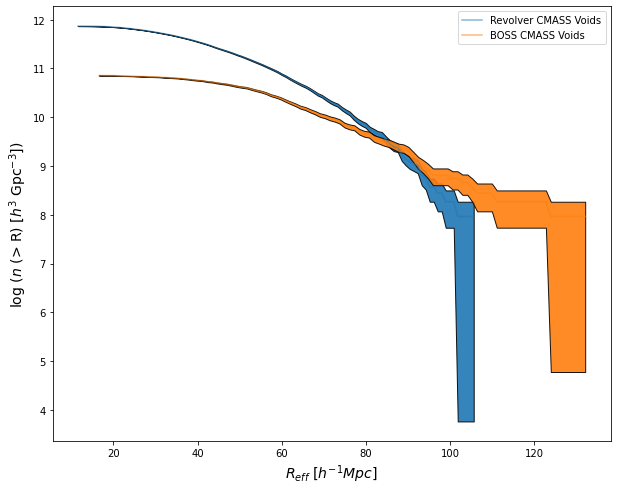

In [22]:
#cumulative number function
nf = numberfunction(radii,vol,labels,a1=a1);

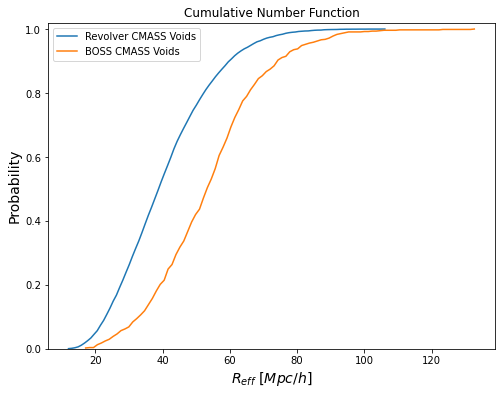

In [25]:
info = plotcdf(datas=radii,labels=labels)
plt.title('Cumulative Number Function');

mode: 41.139
mode count: 2
mean: 53.39460465116279
std: 16.523325454528138
skew: 0.497130221650456
kurtosis: 0.8884692612867999


Text(0.5, 1.0, 'BOSS Voids')

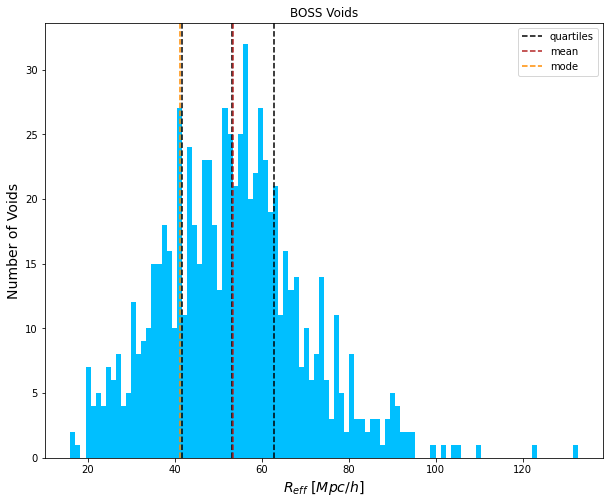

In [26]:
g = getstats(abv['Reff'])
plt.title('BOSS Voids')

mode: 20.8254
mode count: 2
mean: 40.329379681624474
std: 14.260008364035803
skew: 0.6006763653234688
kurtosis: 0.1681389701203697


Text(0.5, 1.0, 'Revolver Voids')

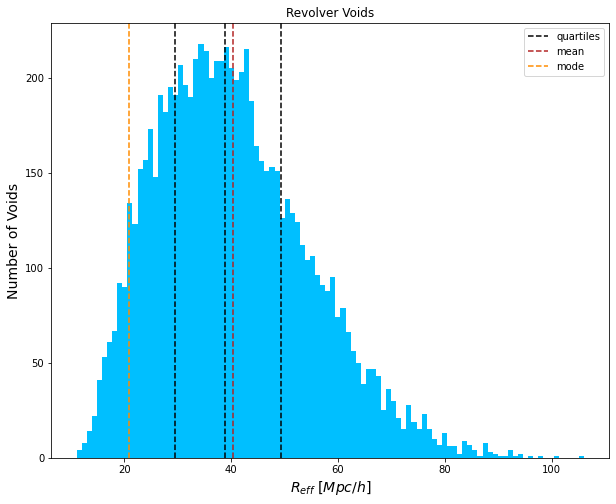

In [27]:
h = getstats(arv['Reff'])
plt.title('Revolver Voids')

In [28]:
def redshift_histograms(bins=40):
    """Redshift histogram plots."""

    fig, ax = plt.subplots(figsize=(8, 6))
    _ = ax.hist(allgal['Z'], bins=bins, range=(0, 1), density=True, label='Parent SDSS Sample')
    _ = ax.hist(arv['Z'], bins=bins, range=(0, 1), alpha=0.7, density=True, label='Revolver Void Sample')
    _ = ax.hist(abv['Z'], bins=bins, range=(0, 1), alpha=0.4, density=True, label='BOSS Void Sample')

    ax.legend(loc='upper left', fontsize=12)
    ax.grid()
    ax.set_ylabel('Relative Density of Objects')
    ax.set_xlabel('Redshift')

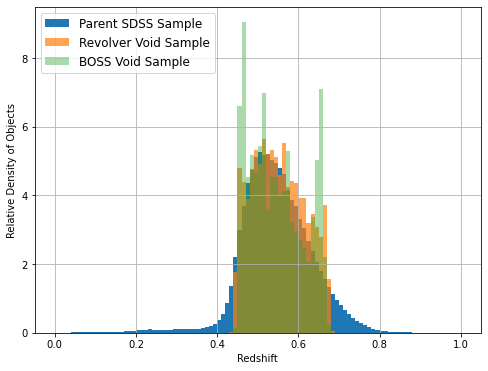

In [29]:
redshift_histograms(bins=100)

Text(0, 0.5, 'Distance to boundary')

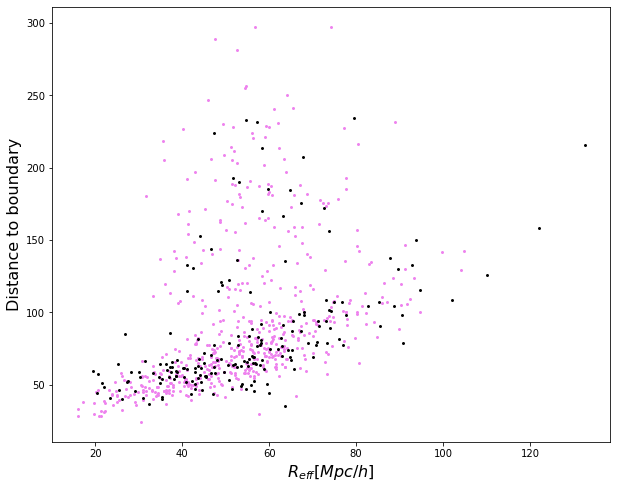

In [31]:
plt.figure(figsize=(10,8))
plt.scatter(nbv['Reff'],nbv['Dboundary'],s=15,color='violet',marker='.')
plt.scatter(sbv['Reff'],sbv['Dboundary'],s=15,color='k',marker='.')
plt.xlabel('$R_{eff} [Mpc/h]$',fontsize = 16)
plt.ylabel('Distance to boundary', fontsize = 16)
#plt.ylim(0,180)
#Figure from Mao et al. 2016

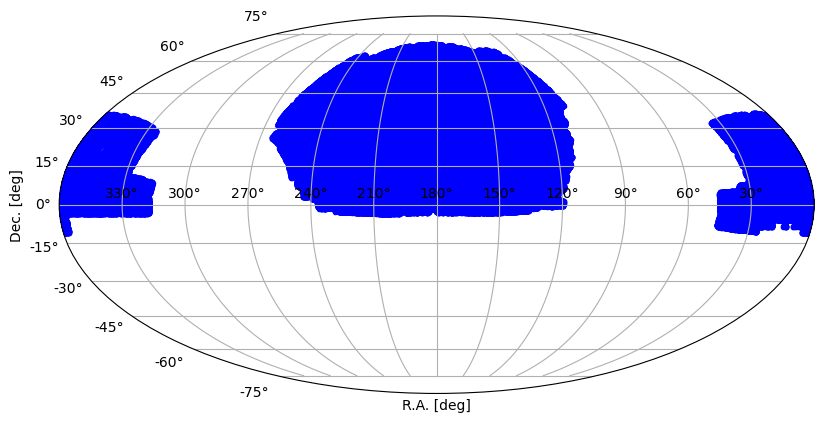

In [43]:
#all the cmass galaxies
cm = plt.cm.get_cmap('bwr')
ax = init_sky(ra_center=180,galactic_plane_color=None,ecliptic_plane_color=None) #default mollweide 
p = ax.scatter(ax.projection_ra(allgal['RA']), ax.projection_dec(allgal['DEC']), marker='.', color='blue',cmap=cm)
#plt.colorbar(p,cmap='cm')

## Void Slices ##

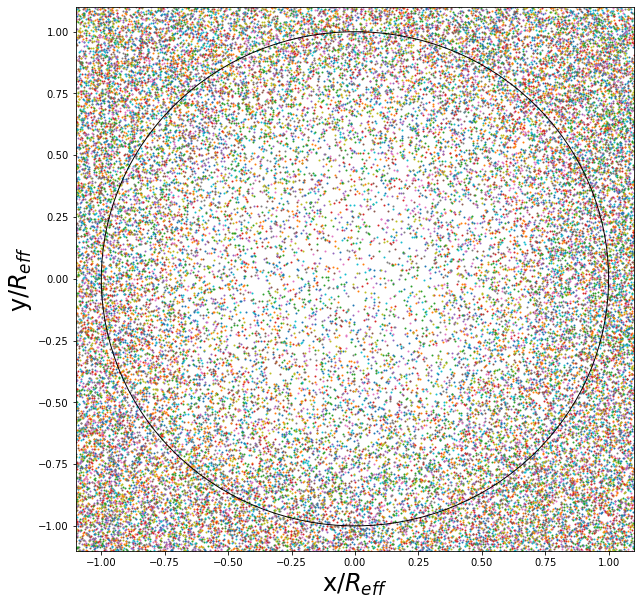

In [46]:
#all galaxies and all boss voids
stackvoids([agal['GX'],agal['GY'],agal['GZ']],[abv['VX'],abv['VY'],abv['VZ']],abv['Reff'],zslice=0.5)

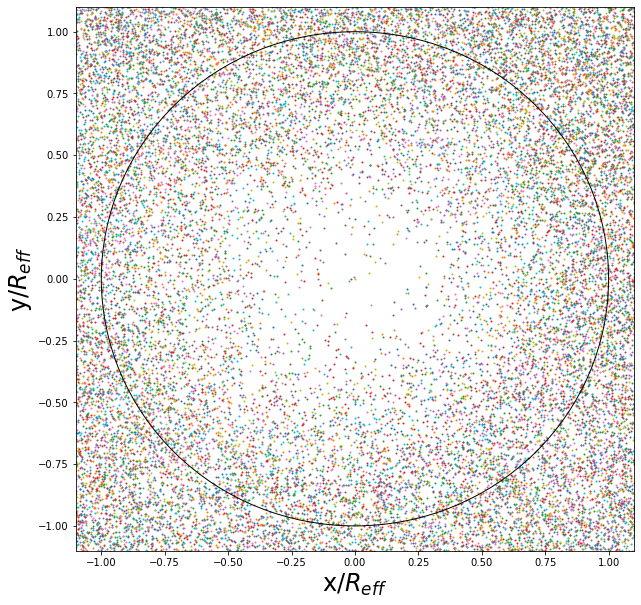

In [50]:
#all north gal and some rev north voids
stackvoids([ngal['GX'],ngal['GY'],ngal['GZ']],[nrv['VX'][:300],nrv['VY'][:300],nrv['VZ'][:300]],nrv['Reff'][:300],zslice=0.5)

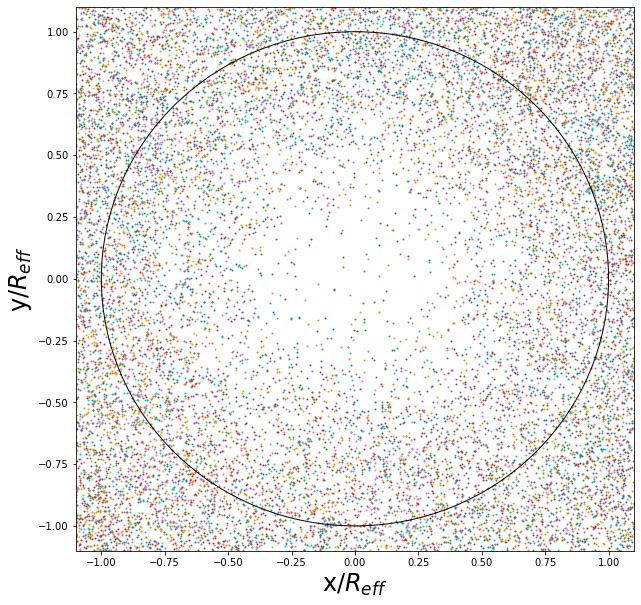

In [49]:
#all south gal and some rev south voids
stackvoids([sgal['GX'],sgal['GY'],sgal['GZ']],[srv['VX'][:300],srv['VY'][:300],srv['VZ'][:300]],srv['Reff'][:300],zslice=0.5)

## UNIT Sims ##

<Figure size 432x288 with 0 Axes>

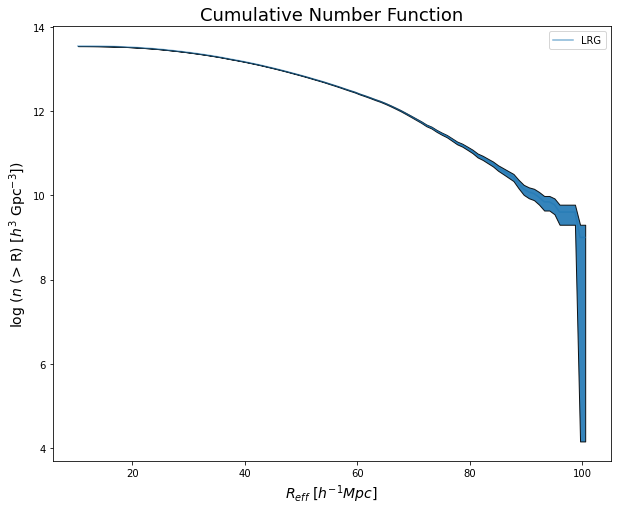

In [32]:
v = 1
nf = numberfunction([lrg[4]],volume=v,labels=['LRG'],a1=0.55)
plt.title('Cumulative Number Function', fontsize=18);

<Figure size 432x288 with 0 Axes>

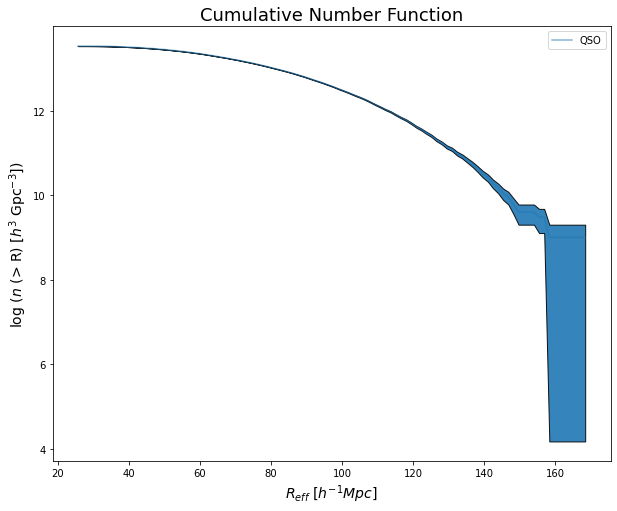

In [33]:
nf = numberfunction([qso[4]],volume=v,labels=['QSO'],a1=0.55)
plt.title('Cumulative Number Function', fontsize=18);

mode: 32.7487
mode count: 4
mean: 38.2876352453865
std: 13.57179129197479
skew: 0.5498144735692353
kurtosis: -0.003063267367716005


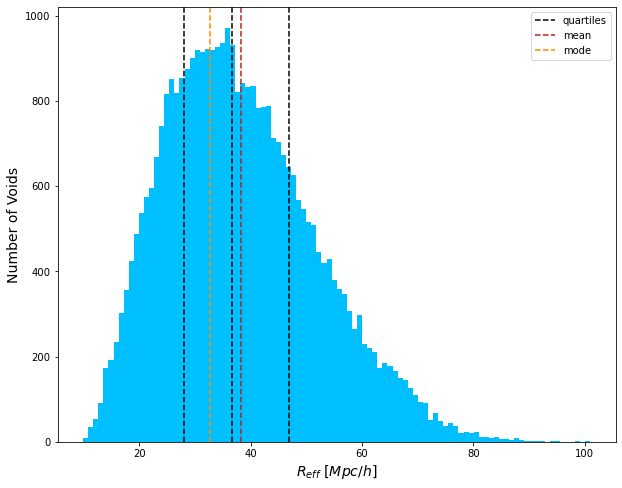

In [34]:
a = getstats(lrg[4])

mode: 55.5333
mode count: 3
mean: 69.76996896674268
std: 20.658818437823413
skew: 0.4325707808086447
kurtosis: -0.18280120607096517


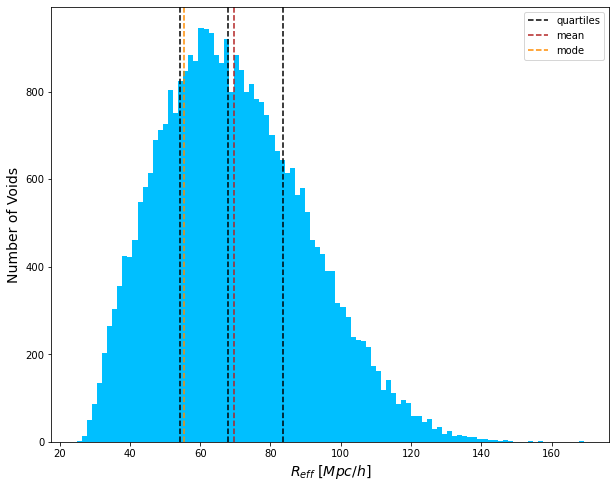

In [35]:
b = getstats(qso[4])

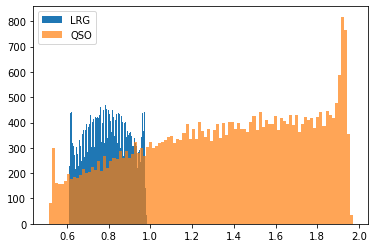

In [30]:
plt.hist(lrg[3], bins=100, label='LRG')
plt.hist(qso[3], bins=100, alpha=0.7, label='QSO')
plt.legend()

## Wedges

In [56]:
ii = 658
zslice= 0.5
islice = np.abs(ngal['GZ'] - nrv['VZ'][ii]) < zslice*nrv['Reff'][ii] #slicing in z 
color = ('r' if nrv['delta_min'][ii]<0 else 'yellow')
buffer = (rbpn[4]!=-60) & (rbpn[3]!=-60) & (np.abs(rbpn[2] - nrv['VZ'][ii]) < zslice*nrv['Reff'][ii]) #slicing in z 

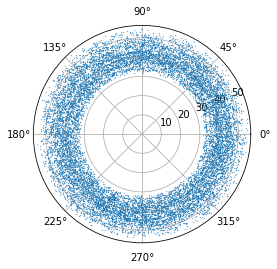

In [53]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(ngal['RA'][islice], ngal['DEC'][islice],'.',markersize=.5)
#ax.set_thetamin(140)
#ax.set_thetamax(240)
#ax.set_rmin(8.5)
#ax.set_rmax(17)

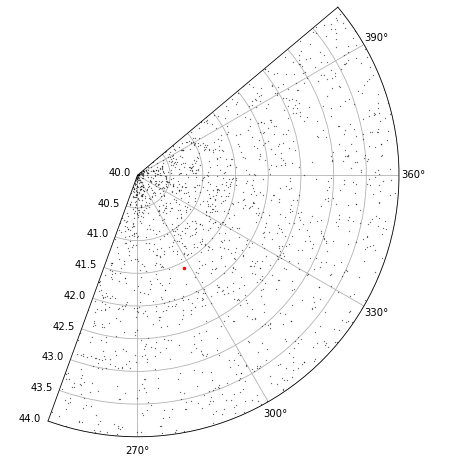

In [59]:
fig, ax = plt.subplots(figsize=(8,8),subplot_kw={'projection': 'polar'})
ax.plot(ngal['RA'][islice], ngal['DEC'][islice],'.',color='k',markersize=.5)
#ax.plot(rbpn[3][buffer],rbpn[4][buffer],'.',color='b',markersize=0.5)
ax.plot(nrv['RA'][ii],nrv['DEC'][ii],'.',color=color,markersize=5)
ax.set_thetamin(250)
ax.set_thetamax(400)
ax.set_rmin(40)
ax.set_rmax(44)

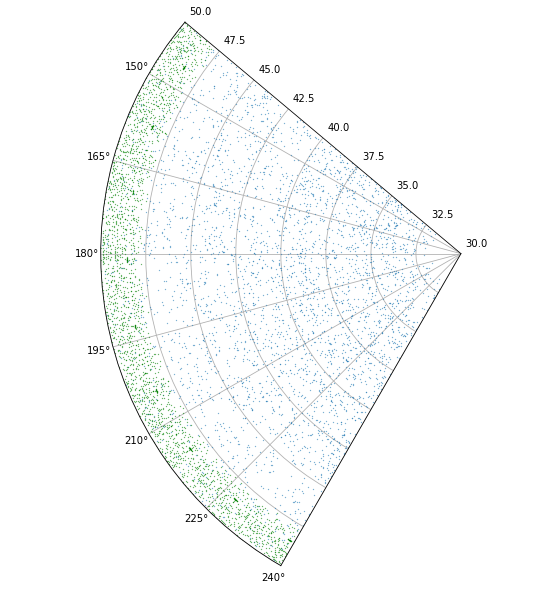

In [57]:
fig, ax = plt.subplots(figsize=(10,10),subplot_kw={'projection': 'polar'})
ax.plot(ngal['RA'][islice], ngal['DEC'][islice],'.',markersize=.5)
ax.plot(nrv['RA'][ii], nrv['DEC'][ii] ,'.',color=color,markersize=2)
ax.plot(rbpn[3][buffer],rbpn[4][buffer],'.',color='green',markersize=0.5)
ax.set_thetamin(140)
ax.set_thetamax(240)
ax.set_rmin(30)
ax.set_rmax(50)

In [58]:
cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.3) #define which cosmology
angdiameter = cosmo.angular_diameter_distance(nrv['Z'][ii])
theta = (nrv['Reff'][ii]/angdiameter.value)* (180/np.pi) #this is in degrees

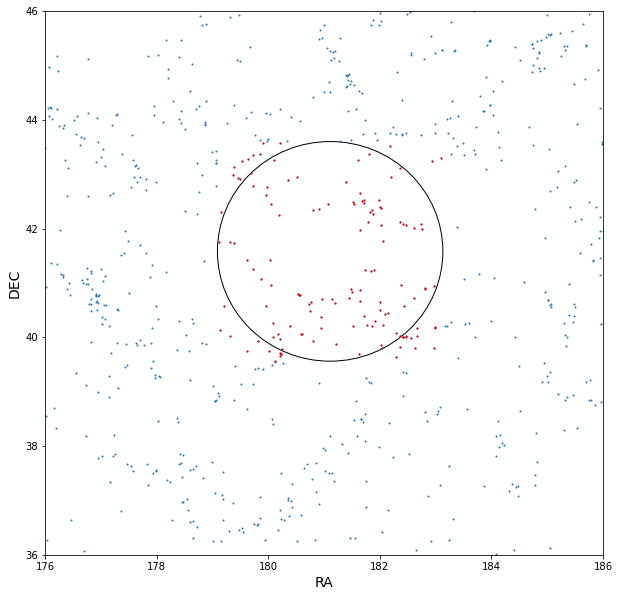

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ngal['RA'][islice],ngal['DEC'][islice],'.',markersize=2)
mask = (ngal['RA'][islice]<(nrv['RA'][ii]+theta)) & (ngal['RA'][islice]>(nrv['RA'][ii]-theta)) & (ngal['DEC'][islice]<(nrv['DEC'][ii]+theta)) & (ngal['DEC'][islice]>(nrv['DEC'][ii]-theta))
ax.plot(ngal['RA'][islice][mask],ngal['DEC'][islice][mask],'.',color='r',markersize=2)

ax.set_xlim(176, 186)
ax.set_ylim(36, 46)
ax.add_patch(Circle((nrv['RA'][ii],nrv['DEC'][ii]), theta,facecolor='none', edgecolor='k'))
ax.set_xlabel('RA',fontsize=14)
ax.set_ylabel('DEC',fontsize=14);
#ax.add_patch(Circle((0, 0), 1.0, facecolor='none', edgecolor='k'))

## Misc.

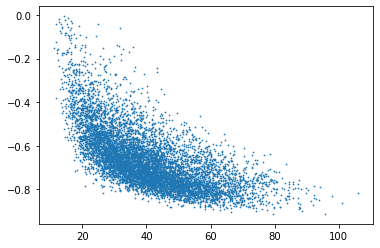

In [39]:
plt.scatter(arv['Reff'], arv['delta_min'],s=0.5)

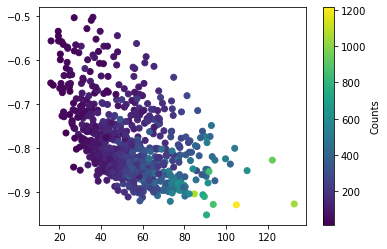

In [41]:
plt.scatter(abv['Reff'], abv['delta_min'],c=abv['Ngal'])  
plt.colorbar(label="Counts")
plt.show()

/global/common/software/desi/cori/desiconda/20211217-2.0.0/code/desiutil/master/py/desiutil/plots.py:480: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


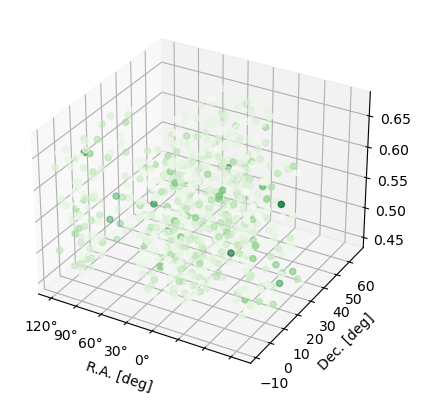

In [44]:
ax = init_sky(projection='3d',ra_center=0, galactic_plane_color=None,ecliptic_plane_color=None)
ax.scatter3D(abv['RA'], abv['DEC'], abv['Z'],c=abv['Ngal'],cmap='Greens');
#p = ax.scatter(ax.projection_ra(abv['RA']), ax.projection_dec(abv['DEC']),marker='.', color='black')
#I wonder what's the z axis

In [ ]:
#rdist = np.sqrt((gx - vx[ii])**2 + (gy - vy[ii])**2 + (gz - vz[ii])**2) # [Mpc]
#diff = gx[:, None] - vx[None, :]
#diff.shape
#np.all(diff[:, ii] == gx - vx[ii])